In [1]:
#bibliotecas
import numpy as np
import pandas as pd
import math as mat
import matplotlib.pyplot as plt
def calcular_factor_escala(MC):
    x_coords = [linea[i] for linea in MC for i in [0, 2]]
    y_coords = [linea[i] for linea in MC for i in [1, 3]]
    max_coord = max(max(x_coords) - min(x_coords), max(y_coords) - min(y_coords))
    factor_escala = max_coord / 10  # Escala las flechas para que sean una décima del tamaño máximo
    return factor_escala


def graficar_porticos(MC):
    for elemento in MC:
        x = [elemento[0], elemento[2]]  # Coordenadas x de inicio y fin
        y = [elemento[1], elemento[3]]  # Coordenadas y de inicio y fin
        plt.plot(x, y, marker='o', linestyle='-', color='b')  # Dibuja el elemento

    # Configuración de la gráfica
    plt.title('Pórticos')
    plt.xlabel('X [m]')
    plt.ylabel('Y [m]')
    plt.grid(True)
    plt.axis('equal')  # Asegura que las proporciones sean iguales
    plt.show()
    
def graficar(MC, MGL):
    fig, ax = plt.subplots(figsize=(15, 8))

    # Calcula el factor de escala
    factor_escala = 1  # Asumimos un factor escala, ajusta según tu cálculo específico

    # Dibujar cada elemento de la cercha
    for i, linea in enumerate(MC):
        ax.plot([linea[0], linea[2]], [linea[1], linea[3]], 'k-', linewidth=2)
        ax.text((linea[0] + linea[2]) / 2, (linea[1] + linea[3]) / 2, str(i), color='red', fontsize=12, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='red', boxstyle='round,pad=0.2'))

    plt.axis('equal')
    plt.grid(True)

    arrow_length = factor_escala * 0.5
    arrow_width = factor_escala * 0.03
    arrow_head_width = factor_escala * 0.2
    arrow_head_length = factor_escala * 0.1
    circle_radius = factor_escala * 0.2

    # Dibujo de las flechas de grados de libertad y sus etiquetas con longitud aumentada
    for i, gl in enumerate(MGL):
        for j in range(2):
            x_start = MC[i][j*2]
            y_start = MC[i][j*2 + 1]

            for k in range(3):  # Aumenta a 3 para incluir el grado de libertad del momento
                gl_index = gl[j*3 + k]
                dx = arrow_length if k == 0 else 0
                dy = arrow_length if k == 1 else 0

                if k < 2:  # Para x e y grados de libertad, usa flechas
                    ax.arrow(x_start, y_start, dx, dy, head_width=arrow_head_width, head_length=arrow_head_length, fc='blue', ec='blue', width=arrow_width, length_includes_head=True)

                if k == 0:  # Ajuste de texto para x
                    text_x = x_start + dx + arrow_head_length / 2
                    text_y = y_start
                    ha, va = 'left', 'center'
                elif k == 1:  # Ajuste de texto para y
                    text_x = x_start
                    text_y = y_start + dy + arrow_head_length / 2
                    ha, va = 'center', 'bottom'
                else:  # Para el momento, dibuja una circunferencia
                    circle = plt.Circle((x_start, y_start), circle_radius, color='green', fill=False, lw=2)
                    ax.add_artist(circle)
                    text_x = x_start + circle_radius * 1.4  # Posición del texto ajustada a la derecha y abajo
                    text_y = y_start - circle_radius * 0.4
                    ha, va = 'right', 'bottom'

                color_texto = 'darkblue' if k < 2 else 'green'  # Texto verde para momentos
                ax.text(text_x, text_y, str(gl_index), color=color_texto, fontsize=12, ha=ha, va=va, bbox=dict(facecolor='white', edgecolor=color_texto, boxstyle='round,pad=0.2'))

    plt.show()

<h1><center>Programa de pórticos y vigas</center></h1>

#### 1. Datos de entrada

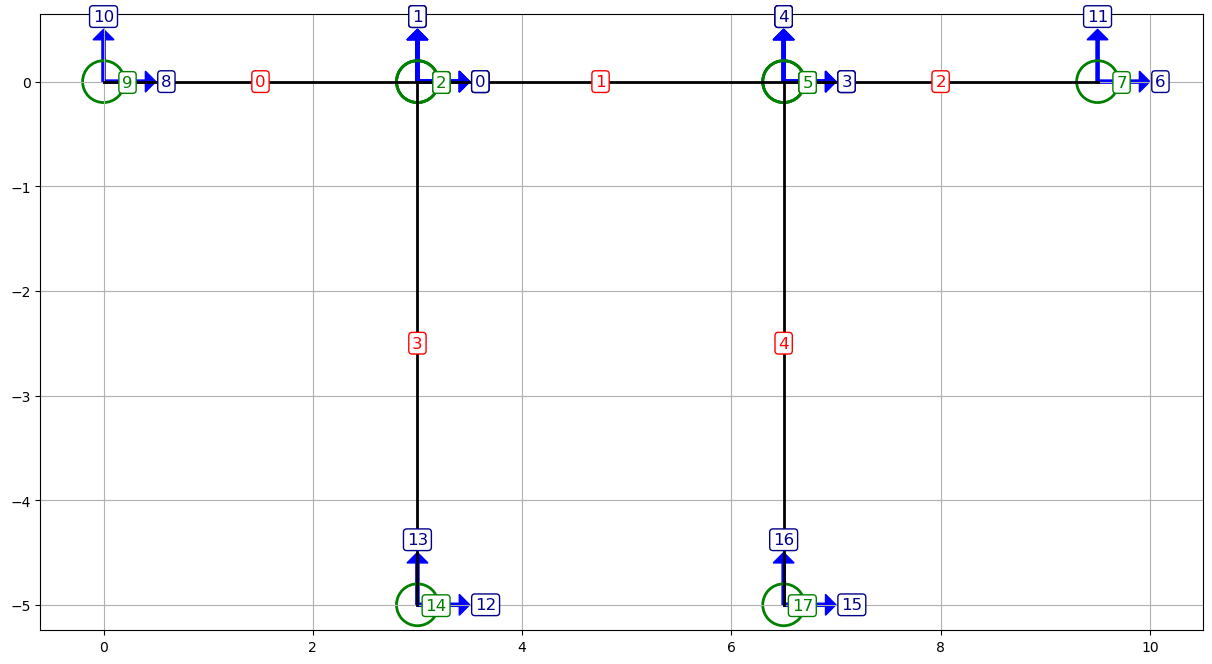

In [2]:
#número de nodos
Nn = 6

#Número de elementos
Ne = 5

#Número de grados de libertas de la estructura, NGL
NGL = 3*Nn

#Matriz de grados de libertad
MGL = [[8,10,9,0,1,2],
       [0,1,2,3,4,5],
       [3,4,5,6,11,7],
       [12,13,14,0,1,2],
       [15,16,17,3,4,5]]

#Matriz de áreas en metros^2
MA = [[0.12],
      [0.12],
      [0.12],
      [0.16],
      [0.16]]

#Matriz de módulos de elasticidad en Kpa
ME = [[20000000],
      [20000000],
      [20000000],
      [20000000],
      [20000000]]

#Matriz de inercias en metros^4

IR = 1/12*(0.3)*(0.6)**3  # inercia rectangulo = 1/12*(BASE)*(ALTURA)^3
IC = (mat.pi*(0.3/2)**4)/4 #inercia de circulo = (pi*(diametro/2)^4)/4

MI = [[1/12*(0.3)*(0.4)**3],
      [1/12*(0.3)*(0.4)**3],
      [1/12*(0.3)*(0.4)**3],
      [1/12*(0.4)*(0.4)**3],
      [1/12*(0.4)*(0.4)**3]]

#Matriz de coordenadas iniciales y finales de cada elemento
MC = [[0,0,3,0],
      [3,0,6.5,0],
      [6.5,0,9.5,0],
      [3,-5,3,0],
      [6.5,-5,6.5,0]]

graficar(MC, MGL)

#### 2. Matriz de longitudes

<h5>Se hace pitagoras para hallar las longitudes de los elementos</h5>

$$ML=\sqrt{(x_2-x_1)^2 + (y_2-y_1)^2}$$

In [3]:
#Matriz de longitud de cada elemento
𝑀𝐿 = np.zeros((Ne,1))

for i in range (Ne):
    ML[i,0]=np.sqrt(((MC[i][2]-MC[i][0]))**2 + (MC[i][3]-MC[i][1])**2)

pd.DataFrame(ML)

,0
0,3.0
1,3.5
2,3.0
3,5.0
4,5.0


#### 3. Matriz de rigidez local para cada elemento

<h5>Para hallar la matriz de rigidez local de cada elemento se utiliza su definición:</h5>

$$
MRL = \begin{bmatrix}
\frac{AE}{L} & 0 & 0 & -\frac{AE}{L} & 0 & 0 \\
0 & \frac{12EI_z}{L^3} & \frac{6EI_z}{L^2} & 0 & -\frac{12EI_z}{L^3} & \frac{6EI_z}{L^2} \\
0 & \frac{6EI_z}{L^2} & \frac{4EI_z}{L} & 0 & -\frac{6EI_z}{L^2} & \frac{2EI_z}{L} \\
-\frac{AE}{L} & 0 & 0 & \frac{AE}{L} & 0 & 0 \\
0 & -\frac{12EI_z}{L^3} & -\frac{6EI_z}{L^2} & 0 & \frac{12EI_z}{L^3} & -\frac{6EI_z}{L^2} \\
0 & \frac{6EI_z}{L^2} & \frac{2EI_z}{L} & 0 & -\frac{6EI_z}{L^2} & \frac{4EI_z}{L} \\
\end{bmatrix}
$$

<h5> Donde: A es el area del elemento, E el módulo de elasticidad y L la longitud </h5>

In [4]:
# Suponiendo que MA, ME, ML y MGL son listas o arrays previamente definidos y Ne es el número de elementos
Ne = len(MA)

MAL = np.zeros ((Ne,6,6))
for i in range (Ne):
    MAL[i,0,0] = (MA[i][0] * ME[i][0]) / ML[i][0]
    MAL[i,1,1] = (12 * ME[i][0] * MI[i][0]) / (ML[i][0]**3)
    MAL[i,2,2] = (4 * ME[i][0] * MI[i][0]) / (ML[i][0])
    MAL[i,3,3] = (MA[i][0] * ME[i][0]) / ML[i][0]
    MAL[i,4,4] = (12 * ME[i][0] * MI[i][0]) / (ML[i][0]**3)
    MAL[i,5,5] = (4 * ME[i][0] * MI[i][0]) / (ML[i][0])
    
    MAL[i,0,3] = -(MA[i][0] * ME[i][0]) / ML[i][0]
    MAL[i,3,0] = -(MA[i][0] * ME[i][0]) / ML[i][0]
    
    MAL[i,1,4] = -(12 * ME[i][0] * MI[i][0]) / (ML[i][0]**3)
    MAL[i,4,1] = -(12 * ME[i][0] * MI[i][0]) / (ML[i][0]**3)
    
    MAL[i,1,5] = (6 * ME[i][0] * MI[i][0]) / (ML[i][0]**2)
    MAL[i,5,1] = (6 * ME[i][0] * MI[i][0]) / (ML[i][0]**2)
    
    MAL[i,2,4] = -(6 * ME[i][0] * MI[i][0]) / (ML[i][0]**2)
    MAL[i,4,2] = -(6 * ME[i][0] * MI[i][0]) / (ML[i][0]**2)
    
    MAL[i,2,5] = (2 * ME[i][0] * MI[i][0]) / (ML[i][0])
    MAL[i,5,2] = (2 * ME[i][0] * MI[i][0]) / (ML[i][0])
    
    MAL[i,4,5] = -(6 * ME[i][0] * MI[i][0]) / (ML[i][0]**2)
    MAL[i,5,4] = -(6 * ME[i][0] * MI[i][0]) / (ML[i][0]**2)

    MAL[i,1,2] = (6 * ME[i][0] * MI[i][0]) / (ML[i][0]**2)
    MAL[i,2,1] = (6 * ME[i][0] * MI[i][0]) / (ML[i][0]**2)

for i in range(Ne):
    print(f"MAL [Elemento {i}]")
    df = pd.DataFrame(MAL[i], index=MGL[i], columns=MGL[i])
    print(df.round(2))
    print("\n")

MAL [Elemento 0]
          8         10        9         0         1         2 
8   800000.0      0.00      0.00 -800000.0      0.00      0.00
10       0.0  14222.22  21333.33       0.0 -14222.22  21333.33
9        0.0  21333.33  42666.67       0.0 -21333.33  21333.33
0  -800000.0      0.00      0.00  800000.0      0.00      0.00
1        0.0 -14222.22 -21333.33       0.0  14222.22 -21333.33
2        0.0  21333.33  21333.33       0.0 -21333.33  42666.67


MAL [Elemento 1]
           0         1         2          3         4         5
0  685714.29      0.00      0.00 -685714.29      0.00      0.00
1       0.00   8956.27  15673.47       0.00  -8956.27  15673.47
2       0.00  15673.47  36571.43       0.00 -15673.47  18285.71
3 -685714.29      0.00      0.00  685714.29      0.00      0.00
4       0.00  -8956.27 -15673.47       0.00   8956.27 -15673.47
5       0.00  15673.47  18285.71       0.00 -15673.47  36571.43


MAL [Elemento 2]
          3         4         5         6         11    

#### 4. Matriz tridimensional de matrices de transformación de cada elemento

<h5>La matriz de transformación se calcula: </h5>  

$$
MAT = 
\begin{bmatrix}
CX & -CX & 0 & 0  & 0 & 0 \\
CY & CX & 0 & 0  & 0 & 0 \\
0 & 0 & 1 & 0 & 0  & 0 \\
0 & 0 & 0 & CX & -CY  & 0 \\
0 & 0 & 0 & CY & CX  & 0 \\
0 & 0 & 0 & 0 & 0 & 1
\end{bmatrix}
\quad
CX = \frac{X_f - X_i}{L}
\quad
CY = \frac{Y_f - Y_i}{L}
$$

In [5]:
MAT = np.zeros((Ne, 6, 6))

for i in range(Ne):
  
    MAT[i,0,0] = (MC[i][2] - MC[i][0]) / ML[i][0]
    MAT[i,0,1] = -(MC[i][3] - MC[i][1]) / ML[i][0]
    MAT[i,1,0] = (MC[i][3] - MC[i][1]) / ML[i][0]
    MAT[i,1,1] = (MC[i][2] - MC[i][0]) / ML[i][0]
    MAT[i,2,2] = 1
    MAT[i,3,3] = (MC[i][2] - MC[i][0]) / ML[i][0]
    MAT[i,3,4] = -(MC[i][3] - MC[i][1]) / ML[i][0]
    MAT[i,4,3] = (MC[i][3] - MC[i][1]) / ML[i][0]
    MAT[i,4,4] = (MC[i][2] - MC[i][0]) / ML[i][0]
    MAT[i,5,5] = 1

for i in range(Ne):
    print(f"MAT [Elemento {i}]")
    df = pd.DataFrame(MAT[i], index=MGL[i], columns=MGL[i])
    print(df)
    print("\n")

MAT [Elemento 0]
     8    10   9    0    1    2 
8   1.0  0.0  0.0  0.0  0.0  0.0
10  0.0  1.0  0.0  0.0  0.0  0.0
9   0.0  0.0  1.0  0.0  0.0  0.0
0   0.0  0.0  0.0  1.0  0.0  0.0
1   0.0  0.0  0.0  0.0  1.0  0.0
2   0.0  0.0  0.0  0.0  0.0  1.0


MAT [Elemento 1]
     0    1    2    3    4    5
0  1.0  0.0  0.0  0.0  0.0  0.0
1  0.0  1.0  0.0  0.0  0.0  0.0
2  0.0  0.0  1.0  0.0  0.0  0.0
3  0.0  0.0  0.0  1.0  0.0  0.0
4  0.0  0.0  0.0  0.0  1.0  0.0
5  0.0  0.0  0.0  0.0  0.0  1.0


MAT [Elemento 2]
     3    4    5    6    11   7 
3   1.0  0.0  0.0  0.0  0.0  0.0
4   0.0  1.0  0.0  0.0  0.0  0.0
5   0.0  0.0  1.0  0.0  0.0  0.0
6   0.0  0.0  0.0  1.0  0.0  0.0
11  0.0  0.0  0.0  0.0  1.0  0.0
7   0.0  0.0  0.0  0.0  0.0  1.0


MAT [Elemento 3]
     12   13   14   0    1    2 
12  0.0 -1.0  0.0  0.0  0.0  0.0
13  1.0  0.0  0.0  0.0  0.0  0.0
14  0.0  0.0  1.0  0.0  0.0  0.0
0   0.0  0.0  0.0  0.0 -1.0  0.0
1   0.0  0.0  0.0  1.0  0.0  0.0
2   0.0  0.0  0.0  0.0  0.0  1.0


MAT [El

#### 5. Matriz tridimensional de matrices de rigidez global de cada elemento

<h5>Expresa las coordenadas de los elementos en coordenadas globales </h5>  

In [6]:
MAG = np.zeros((Ne,6,6))
for i in range(Ne):
    MAG[i] = np.dot(np.dot(MAT[i],MAL[i]),np.transpose(MAT[i]))

for i in range(Ne):
    print(f"MAG [Elemento {i}]")
    df = pd.DataFrame(MAG[i], index=MGL[i], columns=MGL[i])
    print(df.round(2))
    print("\n")

MAG [Elemento 0]
          8         10        9         0         1         2 
8   800000.0      0.00      0.00 -800000.0      0.00      0.00
10       0.0  14222.22  21333.33       0.0 -14222.22  21333.33
9        0.0  21333.33  42666.67       0.0 -21333.33  21333.33
0  -800000.0      0.00      0.00  800000.0      0.00      0.00
1        0.0 -14222.22 -21333.33       0.0  14222.22 -21333.33
2        0.0  21333.33  21333.33       0.0 -21333.33  42666.67


MAG [Elemento 1]
           0         1         2          3         4         5
0  685714.29      0.00      0.00 -685714.29      0.00      0.00
1       0.00   8956.27  15673.47       0.00  -8956.27  15673.47
2       0.00  15673.47  36571.43       0.00 -15673.47  18285.71
3 -685714.29      0.00      0.00  685714.29      0.00      0.00
4       0.00  -8956.27 -15673.47       0.00   8956.27 -15673.47
5       0.00  15673.47  18285.71       0.00 -15673.47  36571.43


MAG [Elemento 2]
          3         4         5         6         11    

#### 6. Matriz de rigidez global de la estructura

In [7]:
KG = np.zeros((NGL,NGL))
for i in range(Ne):
    for j in range (6):
        for k in range (6):
            KG[int(MGL[i][k]),int(MGL[i][j])] = KG[int(MGL[i][k])][int(MGL[i][j])] + MAG[i][j][k]     
pd.DataFrame(KG)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,1.489810e+06,0.000000,10240.000000,-6.857143e+05,0.000000,0.000000,0.0,0.000000,-800000.0,0.000000,0.000000,0.000000,-4096.0,0.0,10240.000000,0.0,0.0,0.000000
1,0.000000e+00,663178.490444,-5659.863946,0.000000e+00,-8956.268222,15673.469388,0.0,0.000000,0.0,-21333.333333,-14222.222222,0.000000,0.0,-640000.0,0.000000,0.0,0.0,0.000000
2,1.024000e+04,-5659.863946,113371.428571,0.000000e+00,-15673.469388,18285.714286,0.0,0.000000,0.0,21333.333333,21333.333333,0.000000,-10240.0,0.0,17066.666667,0.0,0.0,0.000000
3,-6.857143e+05,0.000000,0.000000,1.489810e+06,0.000000,10240.000000,-800000.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,-4096.0,0.0,10240.000000
4,0.000000e+00,-8956.268222,-15673.469388,0.000000e+00,663178.490444,5659.863946,0.0,21333.333333,0.0,0.000000,0.000000,-14222.222222,0.0,0.0,0.000000,0.0,-640000.0,0.000000
5,0.000000e+00,15673.469388,18285.714286,1.024000e+04,5659.863946,113371.428571,0.0,21333.333333,0.0,0.000000,0.000000,-21333.333333,0.0,0.0,0.000000,-10240.0,0.0,17066.666667
6,0.000000e+00,0.000000,0.000000,-8.000000e+05,0.000000,0.000000,800000.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
7,0.000000e+00,0.000000,0.000000,0.000000e+00,21333.333333,21333.333333,0.0,42666.666667,0.0,0.000000,0.000000,-21333.333333,0.0,0.0,0.000000,0.0,0.0,0.000000
8,-8.000000e+05,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,800000.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
9,0.000000e+00,-21333.333333,21333.333333,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.0,42666.666667,21333.333333,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000


<h2><center>Cargas en pórticos y vigas</center></h2>

#### 1. Datos de entrada

In [8]:
#vector de cargas aplicadas en nodos {N0}
N0 = [[0],
      [0],
      [0],
      [0],
      [0],
      [0],
      [0],
      [0],
      [0],
      [0]]

## Numero de grados de libertad libres
NGLL = 10

# Desplazamientos en reacciones
U1 = [[0],
      [0],
      [0],
      [0],
      [0],
      [0],
      [0],
      [0]]

#### 2. Matriz tridimensional de reacciones de empotramiento en coordenadas locales 

</h5> se obtiene con el programa de reacciones<h5>

In [9]:
# Matriz tridimensional de reacciones de empotramiento en coordenadas locales (se ontiene con programa)
MLL = np.zeros((Ne,6,1))
MLL[0] = [[0], [0],[0], [0], [0], [0]]
MLL[1] = [[0], [131.25], [76.5625], [0], [131.25], [-76.5625]]
MLL[2] = [[0], [0],[0], [0], [0], [0]]
MLL[3] = [[0], [61.25], [43.75], [0], [26.25], [-29.16666667]]
MLL[4] = [[0], [-131.25], [-93.75], [0], [-56.25], [62.5]]

#### 3. Matriz tridimensional de reacciones de empotramiento en coordenadas globales

In [10]:
MLG = np.zeros((Ne,6,1))
for i in range(Ne):
    MLG[i] = np.dot(MAT[i], MLL[i])

#### 4. Ensamble el vector {L} de la estructura y subdivídalo en {L 0} y {L 1}.

In [11]:
L = np.zeros((NGL,1))
for i in range(Ne):
    for j in range(6):
        L[MGL[i][j],0] = L[MGL[i][j],0] + MLG[i][j][0]
L0 = L[0:NGLL]
L1 = L[NGLL:NGL]

#### 5. Ensamble {F0}

In [12]:
F0 = N0 - L0

#### 6. Subdivida la matriz de rigidez global de la estructura en las matrices K0, K1, K2 y K3

In [13]:
K0 = KG[0:NGLL, 0:NGLL]
K1 = KG[0:NGLL, NGLL: NGL]
K2 = KG[NGLL: NGL,0:NGLL]
K3 = KG[NGLL:NGL,NGLL:NGL]

<div style= "text-align: center; color: red; font-size: 15px; font-weight: bold;">
    7. desplazamientos en los grados de libertad libres {U0} (desplazamientos desconocidos) y {F1}.
</div>

In [14]:
Feff = F0 - np.dot(K1,U1)
U0 = np.dot((np.linalg.inv(K0)),Feff)
F1 = np.dot(K2,U0) + np.dot(K3, U1)
pd.DataFrame(U0)


,0
0,-0.004179
1,-0.000217
2,-0.000175
3,-0.004245
4,-0.000204
5,0.000614
6,-0.004245
7,-0.000205
8,-0.004179
9,-0.000021


<div style= "text-align: center; color: red; font-size: 15px; font-weight: bold;">
    8. Reacciones {N1}
</div>

In [15]:
N1 = F1 + L1
pd.DataFrame(N1)

,0
0,-1.090696
1,-5.830590
2,-42.344192
3,139.110461
4,-2.023696
5,142.344192
6,130.310825
7,-126.729110


<div style= "text-align: center; color: red; font-size: 15px; font-weight: bold;">
    9. Fuerzas internas en coordenadas globales para cada elemento
</div>


In [16]:
## MU: Matriz de almacenamiento de desplazamientos de cada elemento.
## MFG: Matriz de almacenamiento de fuerzas internas globales de cada elemento.
## U: Vector de desplazamientos de los grados de libertad.
U = np.concatenate((U0,U1))
MU = np.zeros((Ne,6,1))
for i in range (Ne):
    for j in range (6):
        MU [i,j,0]=U[int(MGL[i][j])][0]

MFG = np.zeros((Ne,6,1))
for i in range (Ne):
    MFG[i]=np.dot(MAG[i],MU[i])

pd.DataFrame(U)

,0
0,-0.004179
1,-0.000217
2,-0.000175
3,-0.004245
4,-0.000204
5,0.000614
6,-0.004245
7,-0.000205
8,-0.004179
9,-0.000021


#### 10. Matriz de almacenamiento de los vectores {N} de cada elemento.

In [17]:
MN = np.zeros((Ne,6,1))
for i in range (Ne):
    MN[i] = MLG[i] + MFG[i]

<div style= "text-align: center; color: red; font-size: 15px; font-weight: bold;">
    11. Matriz de almacenamiento de fuerzas locales de cada elemento.
</div>

In [18]:
MFL = np.zeros((Ne,6,1))
for i in range (Ne):
    MFL[i]=np.dot(np.transpose(MAT[i]),MN[i])


for i in range(Ne):
    print(f"MFL [Elemento {i}]")
    df = pd.DataFrame(MFL[i])
    print(df)
    print("\n")


MFL [Elemento 0]
              0
0  0.000000e+00
1 -1.090696e+00
2 -7.771561e-15
3  0.000000e+00
4  1.090696e+00
5 -3.272087e+00


MFL [Elemento 1]
            0
0   45.155808
1  138.019765
2   81.194100
3  -45.155808
4  124.480235
5  -57.499922


MFL [Elemento 2]
              0
0  0.000000e+00
1  5.830590e+00
2  1.749177e+01
3  0.000000e+00
4 -5.830590e+00
5  3.552714e-15


MFL [Elemento 3]
            0
0  139.110461
1   42.344192
2   -2.023696
3 -139.110461
4   45.155808
5  -77.922013


MFL [Elemento 4]
            0
0  130.310825
1 -142.344192
2 -126.729110
3 -130.310825
4  -45.155808
5   40.008152


